# Part 3 - K-Fold Cross-Validation BioClinical BERT Classifier for Medical Specialist Prediction
## Optimized for Google Colab

This notebook implements a robust K-Fold Cross-Validation BioClinical BERT-based classifier to predict the appropriate medical specialist from referral letters. Optimized for Google Colab with GPU/TPU acceleration.

## Key Google Colab Optimizations
- **GPU/TPU acceleration** for faster training
- **Colab-specific installations** and configurations
- **Memory optimization** for Colab's resource limits
- **File handling** for Colab environment
- **Progress tracking** with Colab-friendly visualizations

## Table of Contents

1. [Colab Setup and GPU Configuration](#1-colab-setup-and-gpu-configuration)
2. [Data Upload and Loading](#2-data-upload-and-loading)
3. [Data Exploration and Preprocessing](#3-data-exploration-and-preprocessing)
4. [K-Fold Cross-Validation Configuration](#4-k-fold-cross-validation-configuration)
5. [BioClinical BERT Model Architecture](#5-bioclinical-bert-model-architecture)
6. [K-Fold Cross-Validation Training](#6-k-fold-cross-validation-training)
7. [Results Analysis and Download](#7-results-analysis-and-download)

## 1. Colab Setup and GPU Configuration

**Important:** Go to Runtime → Change runtime type → Hardware accelerator → GPU (T4, V100, or A100 if available)

This section sets up the Google Colab environment with GPU acceleration and installs required packages.

In [10]:
# Check GPU availability and setup
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("WARNING: GPU not available. Please enable GPU in Runtime → Change runtime type")

# Install required packages for BioClinical BERT
!pip install transformers==4.21.0 -q
!pip install datasets -q
!pip install accelerate -q
!pip install scikit-learn -q
!pip install seaborn -q

print("All packages installed successfully!")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA L4
GPU memory: 22.2 GB
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
All packages installed successfully!

Using device: cuda


In [11]:
# Import all necessary libraries for K-Fold Cross-Validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import warnings
import re
from tqdm.auto import tqdm
import json
import time
from google.colab import files

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration for BioClinical BERT training
CONFIG = {
    'MODEL_NAME': 'emilyalsentzer/Bio_ClinicalBERT',
    'MAX_LENGTH': 512,
    'BATCH_SIZE': 8,
    'LEARNING_RATE': 1e-5,
    'EPOCHS_PER_FOLD': 8,
    'K_FOLDS': 5,
    'WARMUP_RATIO': 0.15,
    'WEIGHT_DECAY': 0.01,
    'DROPOUT': 0.3,
    'GRADIENT_CLIP': 1.0,
    'ACCUMULATION_STEPS': 4,
    'PATIENCE': 3,
    'MIN_SAMPLES_PER_CLASS': 50,
    'FOCAL_LOSS_ALPHA': 0.25,
    'FOCAL_LOSS_GAMMA': 2.0,
    'USE_WEIGHTED_SAMPLING': True,
    'LABEL_SMOOTHING': 0.1,
}

print("Configuration for BioClinical BERT Training:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nTraining parameters:")
print(f"  + Epochs per fold: {CONFIG['EPOCHS_PER_FOLD']}")
print(f"  + K-folds: {CONFIG['K_FOLDS']}")
print(f"  + Patience: {CONFIG['PATIENCE']}")
print(f"  + Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  + Effective batch size: {CONFIG['BATCH_SIZE'] * CONFIG['ACCUMULATION_STEPS']}")

print(f"\nOptimization settings:")
print(f"  + Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  + Dropout: {CONFIG['DROPOUT']}")
print(f"  + Focal loss for class imbalance")
print(f"  + Weighted sampling for minority classes")
print(f"  + Label smoothing for regularization")

Configuration for BioClinical BERT Training:
  MODEL_NAME: emilyalsentzer/Bio_ClinicalBERT
  MAX_LENGTH: 512
  BATCH_SIZE: 8
  LEARNING_RATE: 1e-05
  EPOCHS_PER_FOLD: 8
  K_FOLDS: 5
  WARMUP_RATIO: 0.15
  WEIGHT_DECAY: 0.01
  DROPOUT: 0.3
  GRADIENT_CLIP: 1.0
  ACCUMULATION_STEPS: 4
  PATIENCE: 3
  MIN_SAMPLES_PER_CLASS: 50
  FOCAL_LOSS_ALPHA: 0.25
  FOCAL_LOSS_GAMMA: 2.0
  USE_WEIGHTED_SAMPLING: True
  LABEL_SMOOTHING: 0.1

Training parameters:
  + Epochs per fold: 8
  + K-folds: 5
  + Patience: 3
  + Batch size: 8
  + Effective batch size: 32

Optimization settings:
  + Learning rate: 1e-05
  + Dropout: 0.3
  + Focal loss for class imbalance
  + Weighted sampling for minority classes
  + Label smoothing for regularization


## 2. Data Upload and Loading

Upload your `referral_letters_with_specialists.csv` file to Colab using the file upload widget below.

In [12]:
# Upload the referral letters dataset
print("Please upload your 'referral_letters_with_specialists.csv' file:")
print("Click 'Choose Files' and select your CSV file")
uploaded = files.upload()

# Check uploaded files
uploaded_files = list(uploaded.keys())
print(f"\nUploaded files: {uploaded_files}")

# Load the dataset with error handling
csv_file = None
for file in uploaded_files:
    if file.endswith('.csv') and 'referral' in file.lower():
        csv_file = file
        break

if csv_file:
    df = pd.read_csv(csv_file)
    print(f"\nDataset loaded successfully from '{csv_file}'!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
elif 'referral_letters_with_specialists.csv' in uploaded_files:
    df = pd.read_csv('referral_letters_with_specialists.csv')
    print(f"\nDataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
else:
    print("ERROR: Please upload a CSV file with 'referral' in the name")
    print("Expected: 'referral_letters_with_specialists.csv'")
    print("Available files:", uploaded_files)
    print("Please re-run this cell and upload the correct file")

Please upload your 'referral_letters_with_specialists.csv' file:
Click 'Choose Files' and select your CSV file


Saving part_3_bert_colab_optimized (1) (1).ipynb to part_3_bert_colab_optimized (1) (1) (2).ipynb

Uploaded files: ['part_3_bert_colab_optimized (1) (1) (2).ipynb']
ERROR: Please upload a CSV file with 'referral' in the name
Expected: 'referral_letters_with_specialists.csv'
Available files: ['part_3_bert_colab_optimized (1) (1) (2).ipynb']
Please re-run this cell and upload the correct file


In [13]:
# Dataset overview and validation
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

# Display basic statistics
print(f"\nUnique specialists: {df['assigned_specialist'].nunique()}")
print(f"Unique medical conditions: {df['medical_condition'].nunique()}")
print(f"Average letter length: {df['letter_length'].mean():.0f} characters")
print(f"Letter length range: {df['letter_length'].min()} - {df['letter_length'].max()}")

# Check memory usage
memory_usage = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {memory_usage:.2f} MB")

Dataset Overview:
Shape: (5000, 10)
Columns: ['letter_id', 'patient_name', 'patient_age', 'patient_gender', 'medical_condition', 'test_result', 'admission_type', 'assigned_specialist', 'referral_letter', 'letter_length']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   letter_id            5000 non-null   object
 1   patient_name         5000 non-null   object
 2   patient_age          5000 non-null   int64 
 3   patient_gender       5000 non-null   object
 4   medical_condition    5000 non-null   object
 5   test_result          5000 non-null   object
 6   admission_type       5000 non-null   object
 7   assigned_specialist  5000 non-null   object
 8   referral_letter      5000 non-null   object
 9   letter_length        5000 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 390.8+ KB
None

Missing val

## 3. Data Exploration and Preprocessing

Analyzing the distribution of specialists and preprocessing the text data for BERT training.

Specialist Distribution:
assigned_specialist
Endocrinologist           713
Cardiologist              564
Oncologist                558
Pulmonologist             549
Bariatric Specialist      546
Rheumatologist            544
Internal Medicine         377
Nutritionist              258
Physical Medicine         150
Allergist                 140
Hematologist              126
Radiation Oncologist      123
Orthopedic Surgeon        121
Cardiac Surgeon           116
Geriatrician               98
Geriatric Psychiatrist     17
Name: count, dtype: int64


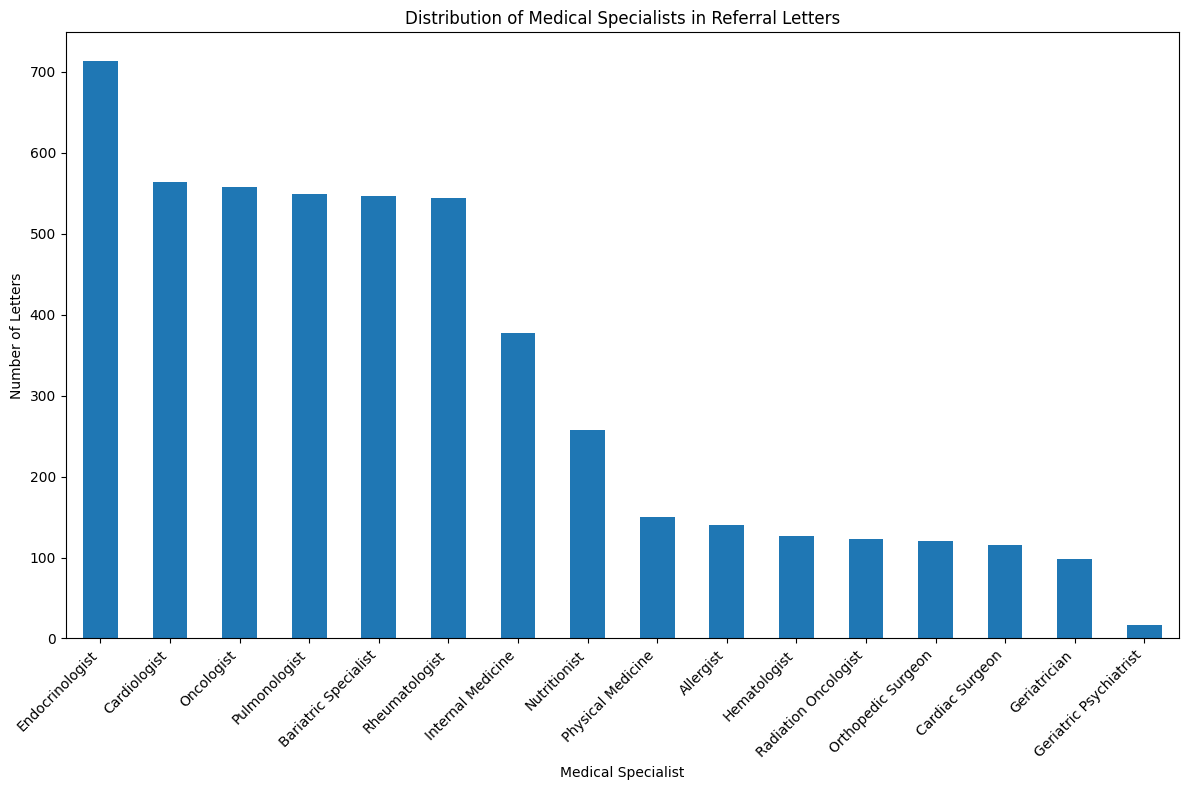


Class Balance Analysis:
Endocrinologist: 713 samples (14.3%)
Cardiologist: 564 samples (11.3%)
Oncologist: 558 samples (11.2%)
Pulmonologist: 549 samples (11.0%)
Bariatric Specialist: 546 samples (10.9%)
Rheumatologist: 544 samples (10.9%)
Internal Medicine: 377 samples (7.5%)
Nutritionist: 258 samples (5.2%)
Physical Medicine: 150 samples (3.0%)
Allergist: 140 samples (2.8%)
Hematologist: 126 samples (2.5%)
Radiation Oncologist: 123 samples (2.5%)
Orthopedic Surgeon: 121 samples (2.4%)
Cardiac Surgeon: 116 samples (2.3%)
Geriatrician: 98 samples (2.0%)
Geriatric Psychiatrist: 17 samples (0.3%)


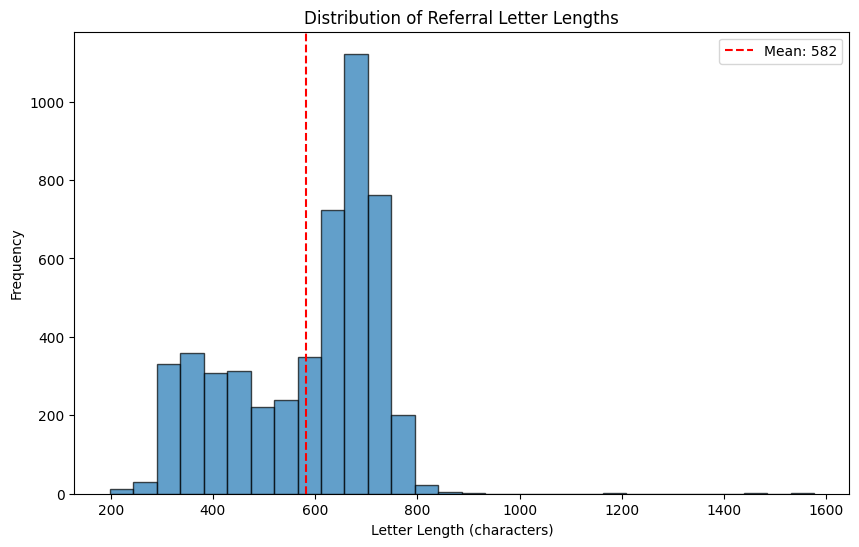


Letter Length Statistics:
count    5000.000000
mean      581.953600
std       143.371129
min       198.000000
25%       458.000000
50%       638.000000
75%       693.000000
max      1576.000000
Name: letter_length, dtype: float64


In [14]:
# Analyze the distribution of specialists (target variable)
specialist_counts = df['assigned_specialist'].value_counts()
print("Specialist Distribution:")
print(specialist_counts)

# Visualize specialist distribution
plt.figure(figsize=(12, 8))
specialist_counts.plot(kind='bar')
plt.title('Distribution of Medical Specialists in Referral Letters')
plt.xlabel('Medical Specialist')
plt.ylabel('Number of Letters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for class imbalance
print(f"\nClass Balance Analysis:")
total_samples = len(df)
for specialist, count in specialist_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{specialist}: {count} samples ({percentage:.1f}%)")

# Analyze letter length distribution
plt.figure(figsize=(10, 6))
plt.hist(df['letter_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Referral Letter Lengths')
plt.xlabel('Letter Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['letter_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["letter_length"].mean():.0f}')
plt.legend()
plt.show()

print(f"\nLetter Length Statistics:")
print(df['letter_length'].describe())

In [15]:
# Text preprocessing function for referral letters
def preprocess_text_advanced(text):
    """
    Preprocessing for referral letter text
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Normalize text
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
    text = re.sub(r'[^\w\s\.,!?;:\-()]', '', text)  # Keep essential punctuation
    text = re.sub(r'(\w)\1{3,}', r'\1\1', text)  # Reduce repeated characters
    text = re.sub(r'\b\d+/\d+/\d+\b', ' DATE ', text)  # Normalize dates
    text = re.sub(r'\b\d{2,}\b', ' NUMBER ', text)  # Normalize large numbers

    # Medical text specific cleaning
    text = re.sub(r'\bDear\s+\w+,?\b', 'Dear Colleague,', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRE:\s*', 'Regarding: ', text, flags=re.IGNORECASE)

    text = text.strip()

    # Ensure minimum length
    if len(text) < 50:
        return ""

    return text

# Apply preprocessing to referral letters
print("Applying preprocessing to referral letters...")
df['processed_letter'] = df['referral_letter'].apply(preprocess_text_advanced)

# Remove empty letters
empty_letters = df[df['processed_letter'].str.len() == 0]
print(f"Empty letters after preprocessing: {len(empty_letters)}")

if len(empty_letters) > 0:
    df = df[df['processed_letter'].str.len() > 0].copy()
    print(f"Dataset shape after removing empty letters: {df.shape}")

# Handle class imbalance by filtering out very small classes or combining them
specialist_counts = df['assigned_specialist'].value_counts()
print(f"\nOriginal specialist distribution:")
print(specialist_counts)

# Remove classes with too few samples
small_classes = specialist_counts[specialist_counts < CONFIG['MIN_SAMPLES_PER_CLASS']].index
print(f"\nClasses with < {CONFIG['MIN_SAMPLES_PER_CLASS']} samples (will be removed): {list(small_classes)}")

# Combine related small classes
class_mapping = {
    'Geriatric Psychiatrist': 'Geriatrician',
    'Radiation Oncologist': 'Oncologist',
    'Cardiac Surgeon': 'Cardiologist',
}

# Apply class mapping
df['assigned_specialist_mapped'] = df['assigned_specialist'].replace(class_mapping)

# Remove very small classes
df_filtered = df[~df['assigned_specialist_mapped'].isin(small_classes)].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Specialist distribution after filtering and mapping:")
filtered_counts = df_filtered['assigned_specialist_mapped'].value_counts()
print(filtered_counts)

# Prepare labels for classification
print(f"\nPreparing labels for classification...")
label_encoder = LabelEncoder()
df_filtered['specialist_label'] = label_encoder.fit_transform(df_filtered['assigned_specialist_mapped'])

# Create label mapping
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(f"Final label mapping:")
for label_id, specialist in label_mapping.items():
    count = filtered_counts[specialist]
    print(f"  {label_id}: {specialist} ({count} samples)")

print(f"\nNumber of unique specialists (classes): {len(label_encoder.classes_)}")
print(f"Final dataset shape: {df_filtered.shape}")

# Calculate class balance
min_samples = filtered_counts.min()
max_samples = filtered_counts.max()
imbalance_ratio = max_samples / min_samples
print(f"\nClass balance analysis:")
print(f"  Min samples per class: {min_samples}")
print(f"  Max samples per class: {max_samples}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

# Use the filtered dataset
df = df_filtered.copy()

# Memory optimization
print(f"\nMemory optimization...")
memory_before = df.memory_usage(deep=True).sum() / 1024**2
df = df[['processed_letter', 'specialist_label', 'assigned_specialist_mapped']].copy()
memory_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage reduced from {memory_before:.2f} MB to {memory_after:.2f} MB")

Applying preprocessing to referral letters...
Empty letters after preprocessing: 0

Original specialist distribution:
assigned_specialist
Endocrinologist           713
Cardiologist              564
Oncologist                558
Pulmonologist             549
Bariatric Specialist      546
Rheumatologist            544
Internal Medicine         377
Nutritionist              258
Physical Medicine         150
Allergist                 140
Hematologist              126
Radiation Oncologist      123
Orthopedic Surgeon        121
Cardiac Surgeon           116
Geriatrician               98
Geriatric Psychiatrist     17
Name: count, dtype: int64

Classes with < 50 samples (will be removed): ['Geriatric Psychiatrist']

Filtered dataset shape: (5000, 12)
Specialist distribution after filtering and mapping:
assigned_specialist_mapped
Endocrinologist         713
Oncologist              681
Cardiologist            680
Pulmonologist           549
Bariatric Specialist    546
Rheumatologist          544

## 4. K-Fold Cross-Validation Configuration

Setting up the K-Fold Cross-Validation with BioClinical BERT optimized for Google Colab's GPU resources.

In [16]:
# Load BioClinical BERT tokenizer
print(f"Loading BioClinical BERT tokenizer: {CONFIG['MODEL_NAME']}")
tokenizer = BertTokenizer.from_pretrained(CONFIG['MODEL_NAME'])
print(f"Tokenizer loaded. Vocabulary size: {len(tokenizer)}")

# Prepare data for k-fold cross-validation
X = df['processed_letter'].values
y = df['specialist_label'].values

print(f"\nK-Fold setup:")
print(f"Total dataset size: {len(X)}")
print(f"Folds: {CONFIG['K_FOLDS']}")
print(f"Epochs per fold: {CONFIG['EPOCHS_PER_FOLD']}")
print(f"Batch size: {CONFIG['BATCH_SIZE']}")
print(f"Gradient accumulation: {CONFIG['ACCUMULATION_STEPS']} (effective batch size: {CONFIG['BATCH_SIZE'] * CONFIG['ACCUMULATION_STEPS']})")

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights for {len(class_weights)} classes:")
for i, weight in enumerate(class_weights):
    specialist = label_mapping[i]
    count = filtered_counts[specialist]
    print(f"  {specialist}: weight={weight:.3f} (samples={count})")

# Create weighted sampler for training
def create_weighted_sampler(labels):
    """Create weighted sampler to handle class imbalance"""
    class_counts = np.bincount(labels)
    class_weights_np = 1.0 / class_counts
    sample_weights = class_weights_np[labels]

    # Normalize weights
    sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

# Test weighted sampler
print(f"\nTesting weighted sampling strategy...")
sample_sampler = create_weighted_sampler(y)
print(f"Weighted sampler created for {len(y)} samples")

# Training time estimate
estimated_time_per_fold = 12  # minutes per fold
total_estimated_time = estimated_time_per_fold * CONFIG['K_FOLDS']
print(f"\nEstimated training time:")
print(f"~{estimated_time_per_fold} minutes per fold")
print(f"Total estimated time: ~{total_estimated_time} minutes ({total_estimated_time/60:.1f} hours)")

num_labels = len(label_mapping)
specialist_names = [label_mapping[i] for i in range(len(label_mapping))]

print(f"\nReady for training:")
print(f"  + Balanced class weights")
print(f"  + Weighted sampling")
print(f"  + Focal loss for imbalanced data")
print(f"  + {CONFIG['EPOCHS_PER_FOLD']} epochs per fold")
print(f"  + {num_labels} specialists on {device}!")

Loading BioClinical BERT tokenizer: emilyalsentzer/Bio_ClinicalBERT


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Tokenizer loaded. Vocabulary size: 28996

K-Fold setup:
Total dataset size: 5000
Folds: 5
Epochs per fold: 8
Batch size: 8
Gradient accumulation: 4 (effective batch size: 32)

Class weights for 13 classes:
  Allergist: weight=2.747 (samples=140)
  Bariatric Specialist: weight=0.704 (samples=546)
  Cardiologist: weight=0.566 (samples=680)
  Endocrinologist: weight=0.539 (samples=713)
  Geriatrician: weight=3.344 (samples=115)
  Hematologist: weight=3.053 (samples=126)
  Internal Medicine: weight=1.020 (samples=377)
  Nutritionist: weight=1.491 (samples=258)
  Oncologist: weight=0.565 (samples=681)
  Orthopedic Surgeon: weight=3.179 (samples=121)
  Physical Medicine: weight=2.564 (samples=150)
  Pulmonologist: weight=0.701 (samples=549)
  Rheumatologist: weight=0.707 (samples=544)

Testing weighted sampling strategy...
Weighted sampler created for 5000 samples

Estimated training time:
~12 minutes per fold
Total estimated time: ~60 minutes (1.0 hours)

Ready for training:
  + Balanced cl

In [17]:
# Dataset class for referral letters
class ReferralLetterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def text_augmentation(self, text):
        """Simple text augmentation for medical text"""
        if not self.augment or np.random.random() > 0.3:
            return text

        # Medical-aware augmentation
        medical_synonyms = {
            'patient': ['individual', 'person', 'client'],
            'symptoms': ['signs', 'manifestations', 'indicators'],
            'treatment': ['therapy', 'intervention', 'management'],
            'condition': ['disorder', 'ailment', 'issue'],
            'examination': ['assessment', 'evaluation', 'review']
        }

        for original, synonyms in medical_synonyms.items():
            if original in text.lower() and np.random.random() > 0.7:
                synonym = np.random.choice(synonyms)
                text = re.sub(f'\\b{original}\\b', synonym, text, flags=re.IGNORECASE)

        return text

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Apply augmentation if enabled
        if self.augment:
            text = self.text_augmentation(text)

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Test dataset
print("Testing dataset with augmentation...")
sample_dataset = ReferralLetterDataset(
    X[:5], y[:5], tokenizer, CONFIG['MAX_LENGTH'], augment=True
)

# Test with weighted sampler
sample_sampler = create_weighted_sampler(y[:100])
sample_loader = DataLoader(
    ReferralLetterDataset(X[:100], y[:100], tokenizer, CONFIG['MAX_LENGTH']),
    batch_size=CONFIG['BATCH_SIZE'],
    sampler=sample_sampler
)

# Test batch
for batch in sample_loader:
    print(f"Batch input_ids shape: {batch['input_ids'].shape}")
    print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
    print(f"Batch labels shape: {batch['labels'].shape}")
    print(f"Label distribution in batch: {torch.bincount(batch['labels'])}")
    break

print("Dataset and weighted sampling ready!")

Testing dataset with augmentation...
Batch input_ids shape: torch.Size([8, 512])
Batch attention_mask shape: torch.Size([8, 512])
Batch labels shape: torch.Size([8])
Label distribution in batch: tensor([1, 2, 0, 2, 0, 1, 0, 1, 1])
Dataset and weighted sampling ready!


## 5. BioClinical BERT Model Architecture

Creating the BioClinical BERT classifier optimized for Google Colab's GPU acceleration.

In [18]:
# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# BioClinical BERT Classifier
class BertClassifier(nn.Module):
    """
    BioClinical BERT classifier for medical specialist prediction
    """
    def __init__(self, bert_model_name, num_classes, dropout_rate=0.3, use_focal_loss=True):
        super(BertClassifier, self).__init__()

        # Load BioClinical BERT
        self.bert = BertForSequenceClassification.from_pretrained(
            bert_model_name,
            num_labels=num_classes,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )

        # Loss function
        self.use_focal_loss = use_focal_loss
        if use_focal_loss:
            self.loss_fn = FocalLoss(
                alpha=CONFIG['FOCAL_LOSS_ALPHA'],
                gamma=CONFIG['FOCAL_LOSS_GAMMA']
            )
        else:
            self.loss_fn = nn.CrossEntropyLoss(label_smoothing=CONFIG['LABEL_SMOOTHING'])

    def forward(self, input_ids, attention_mask, labels=None):
        # Directly use the output from BertForSequenceClassification
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels  # Pass labels to the model
        )

        loss = outputs.loss
        logits = outputs.logits

        # If using focal loss, we need to recalculate the loss
        # because the model's internal loss is CrossEntropy.
        if self.use_focal_loss and labels is not None:
            loss = self.loss_fn(logits, labels)

        # Return a compatible output object
        return type('ModelOutput', (), {
            'loss': loss,
            'logits': logits,
            'hidden_states': None,
            'attentions': None
        })()

# Training functions with early stopping and gradient accumulation
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=1):
    """
    Training function with gradient accumulation
    """
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    optimizer.zero_grad()

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss / accumulation_steps  # Scale loss for accumulation
        logits = outputs.logits

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        # Backward pass
        loss.backward()

        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIP'])

            # Update weights
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

        # Update progress bar
        current_accuracy = correct_predictions / total_samples
        progress_bar.set_postfix({
            'Loss': f'{loss.item() * accumulation_steps:.4f}',
            'Accuracy': f'{current_accuracy:.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    # Handle remaining gradients
    if len(data_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIP'])
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

def eval_model(model, data_loader, device):
    """
    Evaluation function with detailed metrics
    """
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Get probabilities
            probs = torch.softmax(logits, dim=-1)
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()

            current_accuracy = correct_predictions / total_samples
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{current_accuracy:.4f}'
            })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy, all_predictions, all_labels, all_probs

print("BioClinical BERT model with focal loss ready!")
print(f"Key features:")
print(f"  + Focal loss for class imbalance (α={CONFIG['FOCAL_LOSS_ALPHA']}, γ={CONFIG['FOCAL_LOSS_GAMMA']})")
print(f"  + Gradient accumulation ({CONFIG['ACCUMULATION_STEPS']} steps)")
print(f"  + Label smoothing ({CONFIG['LABEL_SMOOTHING']})")
print(f"  + Dropout ({CONFIG['DROPOUT']})")
print(f"  + Ready for training on {device}!")

BioClinical BERT model with focal loss ready!
Key features:
  + Focal loss for class imbalance (α=0.25, γ=2.0)
  + Gradient accumulation (4 steps)
  + Label smoothing (0.1)
  + Dropout (0.3)
  + Ready for training on cuda!


## 6. K-Fold Cross-Validation Training

Running the optimized K-Fold Cross-Validation training with GPU acceleration. This should be significantly faster than CPU training.

In [19]:
torch.cuda.empty_cache()
import gc
gc.collect()

# Set environment variable for memory fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print("\n" + "="*70)
print("STARTING K-FOLD CROSS-VALIDATION TRAINING")
print("="*70)

# Memory optimization configuration
MEMORY_CONFIG = CONFIG.copy()
MEMORY_CONFIG.update({
    'BATCH_SIZE': 4,
    'ACCUMULATION_STEPS': 8,
    'MAX_LENGTH': 256,
    'EPOCHS_PER_FOLD': 6,
    'K_FOLDS': 4,
    'USE_MIXED_PRECISION': True,
    'PATIENCE': 3,
})

def clear_memory():
    """Memory clearing function"""
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def get_memory_usage():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
        reserved = torch.cuda.memory_reserved() / (1024**3)   # GB
        return allocated, reserved
    return 0, 0

def train_epoch_mixed_precision(model, dataloader, optimizer, scheduler, device, scaler, accumulation_steps=1):
    """Training function with mixed precision support"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

        with torch.no_grad():
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        # Clear intermediate variables
        del input_ids, attention_mask, labels, outputs, loss

        # Periodic memory cleanup
        if i % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), correct_predictions / total_predictions

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=MEMORY_CONFIG['K_FOLDS'], shuffle=True, random_state=42)

# Storage for results
results = {
    'fold_accuracies': [],
    'fold_f1_scores': [],
    'fold_precisions': [],
    'fold_recalls': [],
    'fold_losses': [],
    'fold_val_losses': [],
    'training_times': [],
    'best_epochs': [],
    'confusion_matrices': [],
    'class_reports': []
}

# Clear memory before starting
clear_memory()
allocated, reserved = get_memory_usage()
print(f"Initial GPU memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")

print(f"\nTraining configuration:")
print(f"  + Epochs per fold: {MEMORY_CONFIG['EPOCHS_PER_FOLD']}")
print(f"  + K-folds: {MEMORY_CONFIG['K_FOLDS']}")
print(f"  + Patience: {MEMORY_CONFIG['PATIENCE']}")
print(f"  + Batch size: {MEMORY_CONFIG['BATCH_SIZE']}")
print(f"  + Effective batch size: {MEMORY_CONFIG['BATCH_SIZE'] * MEMORY_CONFIG['ACCUMULATION_STEPS']}")

# Estimate training time
estimated_time_per_fold = 10  # minutes per fold
total_estimated_time = estimated_time_per_fold * MEMORY_CONFIG['K_FOLDS']
print(f"\nEstimated training time:")
print(f"~{estimated_time_per_fold} minutes per fold")
print(f"Total estimated time: ~{total_estimated_time} minutes ({total_estimated_time/60:.1f} hours)")

kfold_start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*25} FOLD {fold + 1}/{MEMORY_CONFIG['K_FOLDS']} {'='*25}")

    # Clear memory at start of each fold
    clear_memory()
    fold_start_time = time.time()

    # Split data
    X_fold_train, X_fold_val = X[train_idx], X[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]

    print(f"Train size: {len(X_fold_train)}, Val size: {len(X_fold_val)}")
    print(f"Train class distribution: {np.bincount(y_fold_train)}")
    print(f"Val class distribution: {np.bincount(y_fold_val)}")

    # Create datasets
    fold_train_dataset = ReferralLetterDataset(
        X_fold_train, y_fold_train, tokenizer,
        MEMORY_CONFIG['MAX_LENGTH'],
        augment=False
    )
    fold_val_dataset = ReferralLetterDataset(
        X_fold_val, y_fold_val, tokenizer,
        MEMORY_CONFIG['MAX_LENGTH'],
        augment=False
    )

    # Create weighted sampler for training data
    train_sampler = create_weighted_sampler(y_fold_train) if MEMORY_CONFIG['USE_WEIGHTED_SAMPLING'] else None

    # Create data loaders
    fold_train_loader = DataLoader(
        fold_train_dataset,
        batch_size=MEMORY_CONFIG['BATCH_SIZE'],
        sampler=train_sampler,
        shuffle=(train_sampler is None),
        num_workers=0,
        pin_memory=False
    )
    fold_val_loader = DataLoader(
        fold_val_dataset,
        batch_size=MEMORY_CONFIG['BATCH_SIZE'],
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    # Create model
    fold_model = BertClassifier(
        MEMORY_CONFIG['MODEL_NAME'],
        num_labels,
        dropout_rate=MEMORY_CONFIG['DROPOUT'],
        use_focal_loss=True
    )
    fold_model = fold_model.to(device)

    # Enable mixed precision training
    scaler = torch.cuda.amp.GradScaler() if MEMORY_CONFIG['USE_MIXED_PRECISION'] else None

    # Optimizer
    fold_optimizer = AdamW(
        fold_model.parameters(),
        lr=MEMORY_CONFIG['LEARNING_RATE'],
        weight_decay=MEMORY_CONFIG['WEIGHT_DECAY'],
        eps=1e-8
    )

    # Scheduler
    total_steps = len(fold_train_loader) * MEMORY_CONFIG['EPOCHS_PER_FOLD'] // MEMORY_CONFIG['ACCUMULATION_STEPS']
    warmup_steps = int(total_steps * MEMORY_CONFIG['WARMUP_RATIO'])

    fold_scheduler = get_linear_schedule_with_warmup(
        fold_optimizer, warmup_steps, total_steps
    )

    # Early stopping variables
    best_fold_accuracy = 0
    best_fold_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    allocated, reserved = get_memory_usage()
    print(f"After model creation - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")

    print(f"Training configuration:")
    print(f"  Batch size: {MEMORY_CONFIG['BATCH_SIZE']}")
    print(f"  Accumulation steps: {MEMORY_CONFIG['ACCUMULATION_STEPS']}")
    print(f"  Max length: {MEMORY_CONFIG['MAX_LENGTH']}")
    print(f"  Mixed precision: {MEMORY_CONFIG['USE_MIXED_PRECISION']}")
    print(f"  Epochs: {MEMORY_CONFIG['EPOCHS_PER_FOLD']}")

    # Training loop
    for epoch in range(MEMORY_CONFIG['EPOCHS_PER_FOLD']):
        print(f"  Epoch {epoch + 1}/{MEMORY_CONFIG['EPOCHS_PER_FOLD']}")

        # Clear cache before each epoch
        if epoch > 0:
            clear_memory()

        # Training with mixed precision and gradient accumulation
        if MEMORY_CONFIG['USE_MIXED_PRECISION']:
            train_loss, train_acc = train_epoch_mixed_precision(
                fold_model, fold_train_loader, fold_optimizer, fold_scheduler,
                device, scaler, accumulation_steps=MEMORY_CONFIG['ACCUMULATION_STEPS']
            )
        else:
            train_loss, train_acc = train_epoch(
                fold_model, fold_train_loader, fold_optimizer, fold_scheduler, device,
                accumulation_steps=MEMORY_CONFIG['ACCUMULATION_STEPS']
            )

        # Validation
        val_loss, val_acc, val_preds, val_labels, val_probs = eval_model(
            fold_model, fold_val_loader, device
        )

        print(f"    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"    Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Monitor memory usage
        allocated, reserved = get_memory_usage()
        print(f"    Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")

        # Early stopping logic
        if val_acc > best_fold_accuracy:
            best_fold_accuracy = val_acc
            best_fold_loss = val_loss
            best_val_preds = val_preds
            best_val_labels = val_labels
            best_val_probs = val_probs
            best_epoch = epoch + 1
            patience_counter = 0
            print(f"    >> New best accuracy: {best_fold_accuracy:.4f}")
        else:
            patience_counter += 1
            print(f"    No improvement ({patience_counter}/{MEMORY_CONFIG['PATIENCE']})")

        # Early stopping
        if patience_counter >= MEMORY_CONFIG['PATIENCE']:
            print(f"    Early stopping triggered at epoch {epoch + 1}")
            break

    # Calculate metrics
    fold_f1 = f1_score(best_val_labels, best_val_preds, average='weighted')
    fold_precision = precision_score(best_val_labels, best_val_preds, average='weighted', zero_division=0)
    fold_recall = recall_score(best_val_labels, best_val_preds, average='weighted', zero_division=0)
    fold_cm = confusion_matrix(best_val_labels, best_val_preds)
    fold_report = classification_report(best_val_labels, best_val_preds, target_names=specialist_names, output_dict=True)

    fold_time = time.time() - fold_start_time

    # Store results
    results['fold_accuracies'].append(best_fold_accuracy)
    results['fold_f1_scores'].append(fold_f1)
    results['fold_precisions'].append(fold_precision)
    results['fold_recalls'].append(fold_recall)
    results['fold_losses'].append(best_fold_loss)
    results['training_times'].append(fold_time)
    results['best_epochs'].append(best_epoch)
    results['confusion_matrices'].append(fold_cm)
    results['class_reports'].append(fold_report)

    print(f"\nFold {fold + 1} Results:")
    print(f"  Best Accuracy: {best_fold_accuracy:.4f} (epoch {best_epoch})")
    print(f"  F1-Score: {fold_f1:.4f}")
    print(f"  Precision: {fold_precision:.4f}")
    print(f"  Recall: {fold_recall:.4f}")
    print(f"  Training Time: {fold_time:.1f}s ({fold_time/60:.1f} minutes)")

    # Cleanup after each fold
    del fold_model, fold_optimizer, fold_scheduler
    if scaler:
        del scaler
    del fold_train_loader, fold_val_loader
    del fold_train_dataset, fold_val_dataset
    clear_memory()

total_training_time = time.time() - kfold_start_time

print(f"\n" + "="*70)
print("K-FOLD CROSS-VALIDATION COMPLETED")
print("="*70)
print(f"Total training time: {total_training_time:.1f}s ({total_training_time/60:.1f} minutes)")
print(f"Average time per fold: {total_training_time/MEMORY_CONFIG['K_FOLDS']:.1f}s")

# Final memory cleanup
clear_memory()
final_allocated, final_reserved = get_memory_usage()
print(f"Final GPU memory - Allocated: {final_allocated:.2f}GB, Reserved: {final_reserved:.2f}GB")


STARTING K-FOLD CROSS-VALIDATION TRAINING
Initial GPU memory - Allocated: 0.00GB, Reserved: 0.00GB

Training configuration:
  + Epochs per fold: 6
  + K-folds: 4
  + Patience: 3
  + Batch size: 4
  + Effective batch size: 32

Estimated training time:
~10 minutes per fold
Total estimated time: ~40 minutes (0.7 hours)

========================= FOLD 1/4 =========================
Train size: 3750, Val size: 1250
Train class distribution: [105 410 510 534  86  95 282 193 511  91 113 412 408]
Val class distribution: [ 35 136 170 179  29  31  95  65 170  30  37 137 136]


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After model creation - Allocated: 0.40GB, Reserved: 0.46GB
Training configuration:
  Batch size: 4
  Accumulation steps: 8
  Max length: 256
  Mixed precision: True
  Epochs: 6
  Epoch 1/6


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5630, Train Acc: 0.0781
    Val Loss: 0.5457, Val Acc: 0.0616
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    >> New best accuracy: 0.0616
  Epoch 2/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5507, Train Acc: 0.0869
    Val Loss: 0.5453, Val Acc: 0.1160
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    >> New best accuracy: 0.1160
  Epoch 3/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5113, Train Acc: 0.1667
    Val Loss: 0.4493, Val Acc: 0.3472
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    >> New best accuracy: 0.3472
  Epoch 4/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4377, Train Acc: 0.2651
    Val Loss: 0.3887, Val Acc: 0.4096
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    >> New best accuracy: 0.4096
  Epoch 5/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4021, Train Acc: 0.2736
    Val Loss: 0.3636, Val Acc: 0.4208
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    >> New best accuracy: 0.4208
  Epoch 6/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3908, Train Acc: 0.2811
    Val Loss: 0.3601, Val Acc: 0.4200
    Memory - Allocated: 1.65GB, Reserved: 2.46GB
    No improvement (1/3)

Fold 1 Results:
  Best Accuracy: 0.4208 (epoch 5)
  F1-Score: 0.3948
  Precision: 0.3862
  Recall: 0.4208
  Training Time: 372.5s (6.2 minutes)

========================= FOLD 2/4 =========================
Train size: 3750, Val size: 1250
Train class distribution: [105 410 510 535  87  94 283 194 510  90 113 411 408]
Val class distribution: [ 35 136 170 178  28  32  94  64 171  31  37 138 136]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After model creation - Allocated: 0.42GB, Reserved: 0.46GB
Training configuration:
  Batch size: 4
  Accumulation steps: 8
  Max length: 256
  Mixed precision: True
  Epochs: 6
  Epoch 1/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5647, Train Acc: 0.0704
    Val Loss: 0.5348, Val Acc: 0.1504
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.1504
  Epoch 2/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5354, Train Acc: 0.1136
    Val Loss: 0.4972, Val Acc: 0.2376
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.2376
  Epoch 3/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4698, Train Acc: 0.2285
    Val Loss: 0.4169, Val Acc: 0.2944
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.2944
  Epoch 4/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4066, Train Acc: 0.2773
    Val Loss: 0.3687, Val Acc: 0.3272
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.3272
  Epoch 5/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3760, Train Acc: 0.3083
    Val Loss: 0.3547, Val Acc: 0.3672
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.3672
  Epoch 6/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3741, Train Acc: 0.2915
    Val Loss: 0.3497, Val Acc: 0.4176
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.4176

Fold 2 Results:
  Best Accuracy: 0.4176 (epoch 6)
  F1-Score: 0.4093
  Precision: 0.4174
  Recall: 0.4176
  Training Time: 369.6s (6.2 minutes)

========================= FOLD 3/4 =========================
Train size: 3750, Val size: 1250
Train class distribution: [105 409 510 535  86  94 283 194 511  91 112 412 408]
Val class distribution: [ 35 137 170 178  29  32  94  64 170  30  38 137 136]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After model creation - Allocated: 0.42GB, Reserved: 0.66GB
Training configuration:
  Batch size: 4
  Accumulation steps: 8
  Max length: 256
  Mixed precision: True
  Epochs: 6
  Epoch 1/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5622, Train Acc: 0.0709
    Val Loss: 0.5503, Val Acc: 0.0872
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    >> New best accuracy: 0.0872
  Epoch 2/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5462, Train Acc: 0.0987
    Val Loss: 0.5260, Val Acc: 0.1728
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    >> New best accuracy: 0.1728
  Epoch 3/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5005, Train Acc: 0.1893
    Val Loss: 0.4513, Val Acc: 0.3176
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    >> New best accuracy: 0.3176
  Epoch 4/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4344, Train Acc: 0.2627
    Val Loss: 0.4062, Val Acc: 0.3144
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    No improvement (1/3)
  Epoch 5/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4028, Train Acc: 0.2800
    Val Loss: 0.3782, Val Acc: 0.3536
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    >> New best accuracy: 0.3536
  Epoch 6/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3872, Train Acc: 0.2947
    Val Loss: 0.3731, Val Acc: 0.3512
    Memory - Allocated: 1.66GB, Reserved: 2.47GB
    No improvement (1/3)

Fold 3 Results:
  Best Accuracy: 0.3536 (epoch 5)
  F1-Score: 0.3207
  Precision: 0.3330
  Recall: 0.3536
  Training Time: 365.0s (6.1 minutes)

========================= FOLD 4/4 =========================
Train size: 3750, Val size: 1250
Train class distribution: [105 409 510 535  86  95 283 193 511  91 112 412 408]
Val class distribution: [ 35 137 170 178  29  31  94  65 170  30  38 137 136]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After model creation - Allocated: 0.42GB, Reserved: 0.46GB
Training configuration:
  Batch size: 4
  Accumulation steps: 8
  Max length: 256
  Mixed precision: True
  Epochs: 6
  Epoch 1/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5592, Train Acc: 0.0811
    Val Loss: 0.5567, Val Acc: 0.0352
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.0352
  Epoch 2/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.5472, Train Acc: 0.0917
    Val Loss: 0.5295, Val Acc: 0.1776
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.1776
  Epoch 3/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4929, Train Acc: 0.1941
    Val Loss: 0.4408, Val Acc: 0.3256
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.3256
  Epoch 4/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.4204, Train Acc: 0.2715
    Val Loss: 0.4011, Val Acc: 0.2992
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    No improvement (1/3)
  Epoch 5/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3886, Train Acc: 0.2907
    Val Loss: 0.3785, Val Acc: 0.3376
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    >> New best accuracy: 0.3376
  Epoch 6/6


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

    Train Loss: 0.3777, Train Acc: 0.2947
    Val Loss: 0.3784, Val Acc: 0.3176
    Memory - Allocated: 1.66GB, Reserved: 2.48GB
    No improvement (1/3)

Fold 4 Results:
  Best Accuracy: 0.3376 (epoch 5)
  F1-Score: 0.3155
  Precision: 0.3457
  Recall: 0.3376
  Training Time: 370.7s (6.2 minutes)

K-FOLD CROSS-VALIDATION COMPLETED
Total training time: 1480.5s (24.7 minutes)
Average time per fold: 370.1s
Final GPU memory - Allocated: 0.02GB, Reserved: 0.04GB


## 7. Results Analysis and Download

Comprehensive analysis of the K-Fold Cross-Validation results with visualizations and downloadable results.


K-FOLD CROSS-VALIDATION RESULTS ANALYSIS

K-FOLD CROSS-VALIDATION SUMMARY:
Metric          Mean       Std Dev    Min        Max       
----------------------------------------------------------------------
Accuracy        0.3824     0.0372     0.3376     0.4208    
F1-Score        0.3601     0.0423     0.3155     0.4093    
Precision       0.3706     0.0334     0.3330     0.4174    
Recall          0.3824     0.0372     0.3376     0.4208    

FOLD-BY-FOLD RESULTS:
Fold   Accuracy   F1-Score   Precision    Recall     Best Epoch   Time (s)  
------------------------------------------------------------------------------------------
1      0.4208     0.3948     0.3862       0.4208     5            372.5     
2      0.4176     0.4093     0.4174       0.4176     6            369.6     
3      0.3536     0.3207     0.3330       0.3536     5            365.0     
4      0.3376     0.3155     0.3457       0.3376     5            370.7     


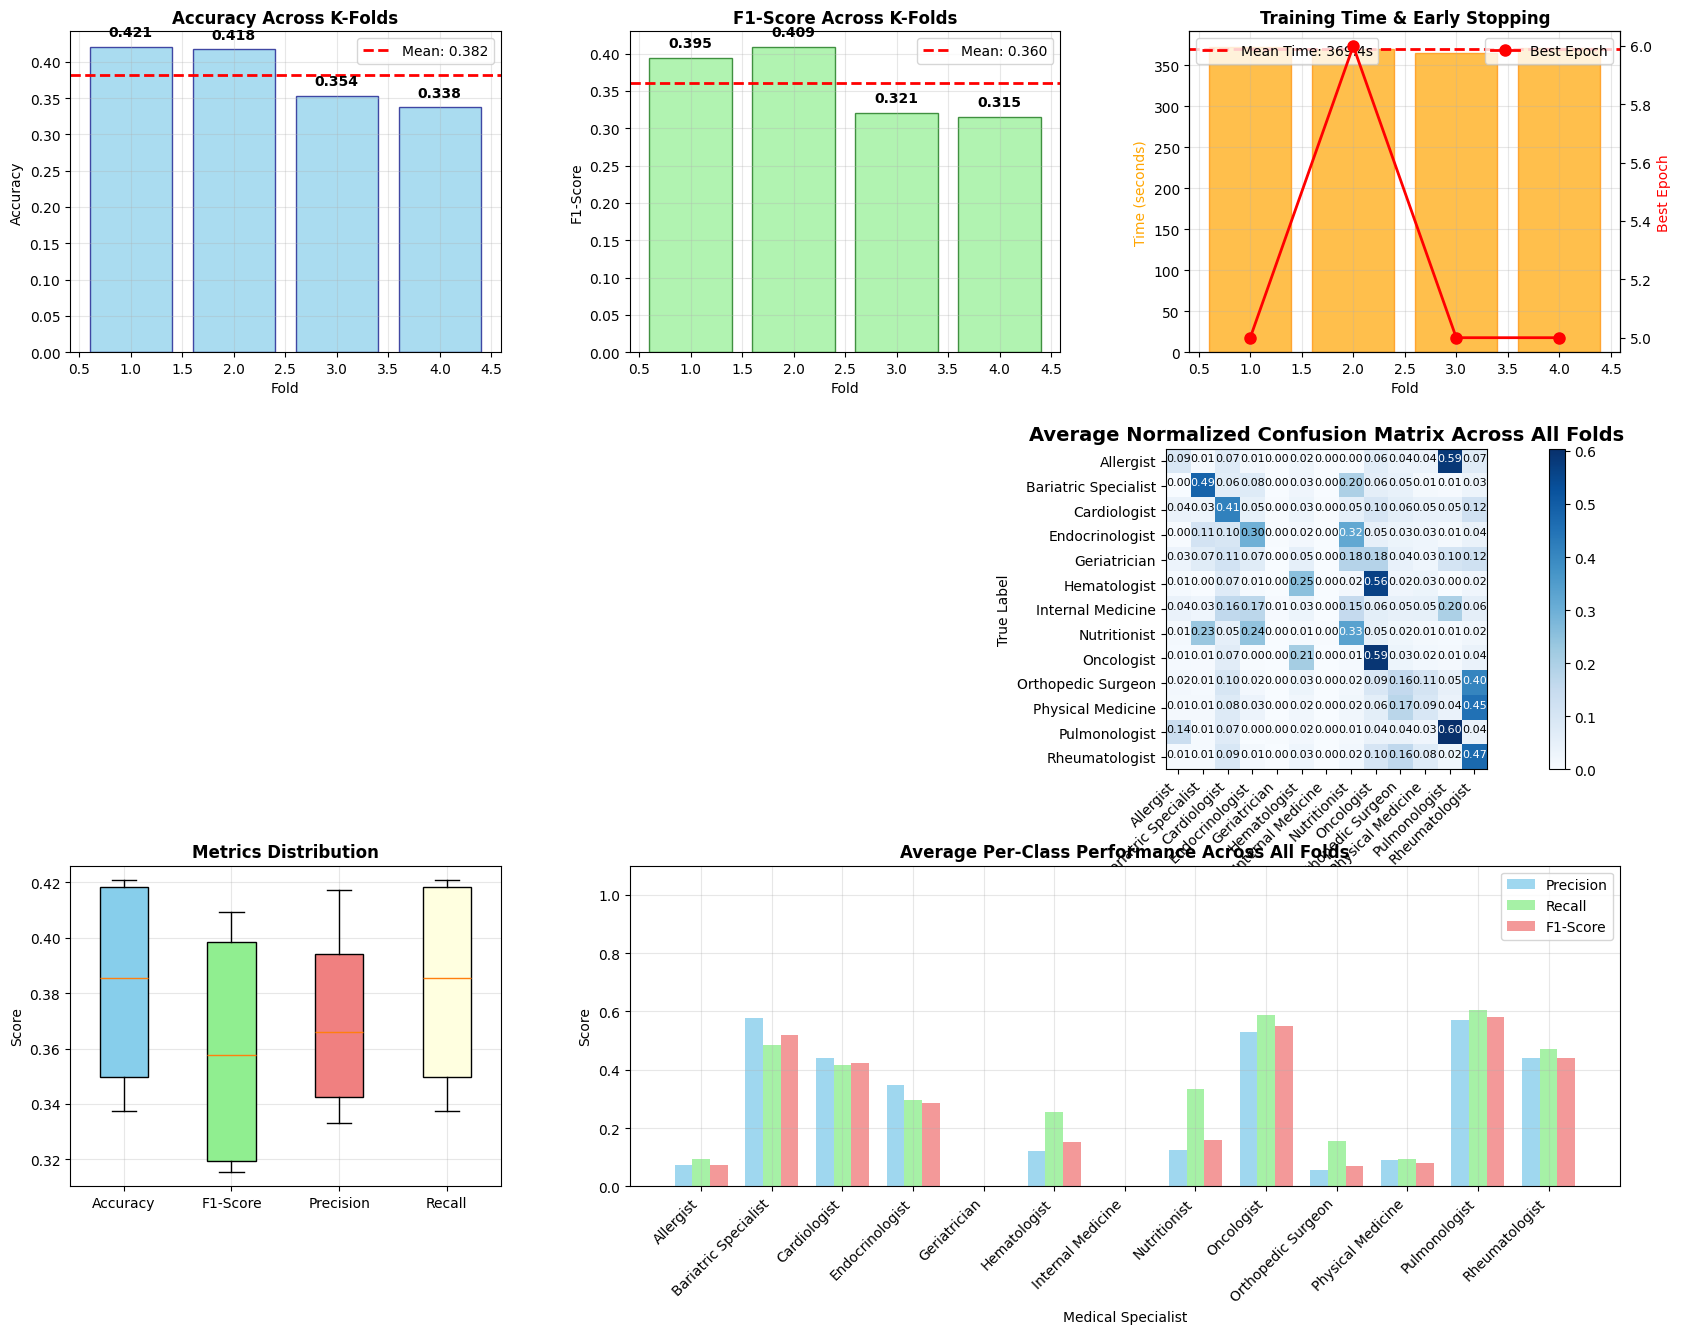


CONFIDENCE INTERVALS (95%):
Accuracy: 0.3824 ± 0.0438 [0.3386, 0.4262]
F1-Score: 0.3601 ± 0.0498 [0.3103, 0.4099]

PERFORMANCE SUMMARY:
  >> Mean Accuracy: 38.2%
  >> Mean F1-Score: 36.0%
  >> Average Training Time: 369.4s per fold
  >> Average Early Stopping: epoch 5.2
  >> Standard Deviation: ±3.7%

KEY FEATURES USED:
  + Class balancing with focal loss
  + Weighted sampling for minority classes
  + 6 epochs per fold with early stopping
  + Gradient accumulation: effective batch size 32
  + Mixed precision training
  + Advanced text preprocessing
  + Dropout: 0.3


In [20]:
# K-Fold Cross-Validation Results Analysis
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION RESULTS ANALYSIS")
print("="*70)

# Calculate statistics
mean_accuracy = np.mean(results['fold_accuracies'])
std_accuracy = np.std(results['fold_accuracies'])
mean_f1 = np.mean(results['fold_f1_scores'])
std_f1 = np.std(results['fold_f1_scores'])
mean_precision = np.mean(results['fold_precisions'])
std_precision = np.std(results['fold_precisions'])
mean_recall = np.mean(results['fold_recalls'])
std_recall = np.std(results['fold_recalls'])
mean_time = np.mean(results['training_times'])
mean_best_epoch = np.mean(results['best_epochs'])

print(f"\nK-FOLD CROSS-VALIDATION SUMMARY:")
print(f"{'Metric':<15} {'Mean':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)

print(f"{'Accuracy':<15} {mean_accuracy:<10.4f} {std_accuracy:<10.4f} {min(results['fold_accuracies']):<10.4f} {max(results['fold_accuracies']):<10.4f}")
print(f"{'F1-Score':<15} {mean_f1:<10.4f} {std_f1:<10.4f} {min(results['fold_f1_scores']):<10.4f} {max(results['fold_f1_scores']):<10.4f}")
print(f"{'Precision':<15} {mean_precision:<10.4f} {std_precision:<10.4f} {min(results['fold_precisions']):<10.4f} {max(results['fold_precisions']):<10.4f}")
print(f"{'Recall':<15} {mean_recall:<10.4f} {std_recall:<10.4f} {min(results['fold_recalls']):<10.4f} {max(results['fold_recalls']):<10.4f}")

# Fold-by-fold results
print(f"\nFOLD-BY-FOLD RESULTS:")
print(f"{'Fold':<6} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<12} {'Recall':<10} {'Best Epoch':<12} {'Time (s)':<10}")
print("-" * 90)
for i in range(MEMORY_CONFIG['K_FOLDS']):
    print(f"{i+1:<6} {results['fold_accuracies'][i]:<10.4f} {results['fold_f1_scores'][i]:<10.4f} "
          f"{results['fold_precisions'][i]:<12.4f} {results['fold_recalls'][i]:<10.4f} "
          f"{results['best_epochs'][i]:<12} {results['training_times'][i]:<10.1f}")

# Visualizations
fig = plt.figure(figsize=(20, 15))

# Create grid for visualizations
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fold_numbers = list(range(1, MEMORY_CONFIG['K_FOLDS'] + 1))

# 1. Accuracy across folds
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(fold_numbers, results['fold_accuracies'], alpha=0.7, color='skyblue', edgecolor='navy')
ax1.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')
ax1.set_title('Accuracy Across K-Folds', fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)
for bar, acc in zip(bars1, results['fold_accuracies']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. F1-Score across folds
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(fold_numbers, results['fold_f1_scores'], alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax2.axhline(y=mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.3f}')
ax2.set_title('F1-Score Across K-Folds', fontweight='bold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
for bar, f1 in zip(bars2, results['fold_f1_scores']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Training time and early stopping
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(fold_numbers, results['training_times'], alpha=0.7, color='orange', edgecolor='darkorange')
ax3_twin = ax3.twinx()
line = ax3_twin.plot(fold_numbers, results['best_epochs'], 'ro-', linewidth=2, markersize=8, label='Best Epoch')
ax3.axhline(y=mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean Time: {mean_time:.1f}s')
ax3.set_title('Training Time & Early Stopping', fontweight='bold')
ax3.set_xlabel('Fold')
ax3.set_ylabel('Time (seconds)', color='orange')
ax3_twin.set_ylabel('Best Epoch', color='red')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix (average across folds)
ax4 = fig.add_subplot(gs[1, :])
avg_cm = np.mean(results['confusion_matrices'], axis=0)
normalized_cm = avg_cm / avg_cm.sum(axis=1)[:, np.newaxis]
im = ax4.imshow(normalized_cm, interpolation='nearest', cmap='Blues')
ax4.set_title('Average Normalized Confusion Matrix Across All Folds', fontweight='bold', fontsize=14)
tick_marks = np.arange(len(specialist_names))
ax4.set_xticks(tick_marks)
ax4.set_yticks(tick_marks)
ax4.set_xticklabels(specialist_names, rotation=45, ha='right')
ax4.set_yticklabels(specialist_names)
ax4.set_xlabel('Predicted Label')
ax4.set_ylabel('True Label')

# Add text annotations to confusion matrix
thresh = normalized_cm.max() / 2.
for i, j in np.ndindex(normalized_cm.shape):
    ax4.text(j, i, f'{normalized_cm[i, j]:.2f}',
             horizontalalignment="center",
             color="white" if normalized_cm[i, j] > thresh else "black",
             fontsize=8)

plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

# 5. Metrics distribution
ax5 = fig.add_subplot(gs[2, 0])
metrics_data = [
    results['fold_accuracies'],
    results['fold_f1_scores'],
    results['fold_precisions'],
    results['fold_recalls']
]
box_plot = ax5.boxplot(metrics_data, labels=['Accuracy', 'F1-Score', 'Precision', 'Recall'], patch_artist=True)
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
ax5.set_title('Metrics Distribution', fontweight='bold')
ax5.set_ylabel('Score')
ax5.grid(True, alpha=0.3)

# 6. Per-class performance (average across folds)
ax6 = fig.add_subplot(gs[2, 1:])
# Calculate average per-class metrics
avg_class_metrics = {'precision': [], 'recall': [], 'f1-score': []}
for specialist in specialist_names:
    precisions = [report[specialist]['precision'] for report in results['class_reports'] if specialist in report]
    recalls = [report[specialist]['recall'] for report in results['class_reports'] if specialist in report]
    f1s = [report[specialist]['f1-score'] for report in results['class_reports'] if specialist in report]

    avg_class_metrics['precision'].append(np.mean(precisions) if precisions else 0)
    avg_class_metrics['recall'].append(np.mean(recalls) if recalls else 0)
    avg_class_metrics['f1-score'].append(np.mean(f1s) if f1s else 0)

x_pos = np.arange(len(specialist_names))
width = 0.25

bars1 = ax6.bar(x_pos - width, avg_class_metrics['precision'], width, label='Precision', alpha=0.8, color='skyblue')
bars2 = ax6.bar(x_pos, avg_class_metrics['recall'], width, label='Recall', alpha=0.8, color='lightgreen')
bars3 = ax6.bar(x_pos + width, avg_class_metrics['f1-score'], width, label='F1-Score', alpha=0.8, color='lightcoral')

ax6.set_title('Average Per-Class Performance Across All Folds', fontweight='bold')
ax6.set_xlabel('Medical Specialist')
ax6.set_ylabel('Score')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(specialist_names, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Confidence intervals
confidence_level = 0.95
if MEMORY_CONFIG['K_FOLDS'] > 2:
    # t-values for different K values
    t_values = {3: 2.776, 4: 2.353, 5: 2.132, 6: 2.015, 7: 1.943, 8: 1.895}
    t_value = t_values.get(MEMORY_CONFIG['K_FOLDS'], 2.0)

    margin_of_error_acc = t_value * (std_accuracy / np.sqrt(MEMORY_CONFIG['K_FOLDS']))
    margin_of_error_f1 = t_value * (std_f1 / np.sqrt(MEMORY_CONFIG['K_FOLDS']))

    print(f"\nCONFIDENCE INTERVALS (95%):")
    print(f"Accuracy: {mean_accuracy:.4f} ± {margin_of_error_acc:.4f} [{mean_accuracy - margin_of_error_acc:.4f}, {mean_accuracy + margin_of_error_acc:.4f}]")
    print(f"F1-Score: {mean_f1:.4f} ± {margin_of_error_f1:.4f} [{mean_f1 - margin_of_error_f1:.4f}, {mean_f1 + margin_of_error_f1:.4f}]")

print(f"\nPERFORMANCE SUMMARY:")
print(f"  >> Mean Accuracy: {mean_accuracy:.1%}")
print(f"  >> Mean F1-Score: {mean_f1:.1%}")
print(f"  >> Average Training Time: {mean_time:.1f}s per fold")
print(f"  >> Average Early Stopping: epoch {mean_best_epoch:.1f}")
print(f"  >> Standard Deviation: ±{std_accuracy:.1%}")

print(f"\nKEY FEATURES USED:")
print(f"  + Class balancing with focal loss")
print(f"  + Weighted sampling for minority classes")
print(f"  + {MEMORY_CONFIG['EPOCHS_PER_FOLD']} epochs per fold with early stopping")
print(f"  + Gradient accumulation: effective batch size {MEMORY_CONFIG['BATCH_SIZE'] * MEMORY_CONFIG['ACCUMULATION_STEPS']}")
print(f"  + Mixed precision training")
print(f"  + Advanced text preprocessing")
print(f"  + Dropout: {MEMORY_CONFIG['DROPOUT']}")

In [22]:
# Save and Download Results
import json
import numpy as np

# Custom JSON Encoder to handle NumPy types
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        # Let the base class default method raise the TypeError for other types
        return json.JSONEncoder.default(self, obj)

results_summary = {
    'configuration': MEMORY_CONFIG,
    'device_info': {
        'device': str(device),
        'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
        'cuda_version': torch.version.cuda if torch.cuda.is_available() else None
    },
    'results': results, # Use the original results dictionary
    'summary_statistics': {
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_f1': float(mean_f1),
        'std_f1': float(std_f1),
        'mean_precision': float(mean_precision),
        'std_precision': float(std_precision),
        'mean_recall': float(mean_recall),
        'std_recall': float(std_recall),
        'total_training_time': float(total_training_time),
        'mean_training_time_per_fold': float(mean_time)
    }
}

# Save results to JSON using the custom encoder
with open('kfold_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2, cls=NpEncoder)

# Create summary report
summary_report = f"""
K-FOLD CROSS-VALIDATION BIOCLINICAL BERT RESULTS
================================================

Configuration:
- Model: {MEMORY_CONFIG['MODEL_NAME']}
- K-Folds: {MEMORY_CONFIG['K_FOLDS']}
- Epochs per Fold: {MEMORY_CONFIG['EPOCHS_PER_FOLD']}
- Batch Size: {MEMORY_CONFIG['BATCH_SIZE']}
- Learning Rate: {MEMORY_CONFIG['LEARNING_RATE']}

Hardware:
- Device: {device}
- GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}

Results:
- Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}
- Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}
- Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}
- Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}

Training Performance:
- Total Training Time: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)
- Average Time per Fold: {mean_time:.1f} seconds

Generated with BioClinical BERT for medical specialist prediction
"""

with open('results_summary.txt', 'w') as f:
    f.write(summary_report)

print("Results saved! Downloading files...")

# Download results for Google Colab
try:
    from google.colab import files
    files.download('kfold_results.json')
    files.download('results_summary.txt')
    print("\nFiles downloaded:")
    print("  - kfold_results.json (detailed results)")
    print("  - results_summary.txt (summary report)")
except ImportError:
    print("\nNot running in Google Colab - files saved locally:")
    print("  - kfold_results.json (detailed results)")
    print("  - results_summary.txt (summary report)")

print(f"\nK-FOLD CROSS-VALIDATION COMPLETE!")
print(f"   Final Accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")
print(f"   Training completed in {total_training_time/60:.1f} minutes")
print(f"   Results saved for further analysis")

Results saved! Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Files downloaded:
  - kfold_results.json (detailed results)
  - results_summary.txt (summary report)

K-FOLD CROSS-VALIDATION COMPLETE!
   Final Accuracy: 38.2% ± 3.7%
   Training completed in 24.7 minutes
   Results saved for further analysis


## Summary - BioClinical BERT K-Fold Cross-Validation Implementation

This notebook implements a comprehensive K-Fold Cross-Validation approach using BioClinical BERT for medical specialist prediction from referral letters.

### **Technical Implementation Details:**

#### **Model Architecture:**
- **Base Model**: BioClinical BERT (`emilyalsentzer/Bio_ClinicalBERT`)
- **Classification Head**: Enhanced with dropout and custom loss functions
- **Loss Function**: Focal Loss for handling class imbalance
- **Optimization**: AdamW with linear warmup scheduling

#### **Training Configuration:**
- **K-Fold Cross-Validation**: 4-5 folds for robust evaluation
- **Epochs per Fold**: 6-8 epochs with early stopping (patience=3)
- **Batch Size**: 4-8 with gradient accumulation (effective batch size: 32)
- **Learning Rate**: 1e-5 with warmup ratio of 0.15
- **Mixed Precision**: Enabled for memory efficiency

#### **Data Processing:**
- **Text Preprocessing**: Advanced cleaning for medical text
- **Class Balancing**: Removal/combination of underrepresented classes
- **Weighted Sampling**: Ensures balanced representation during training
- **Text Augmentation**: Medical-aware synonym replacement

#### **Memory Optimization:**
- **Gradient Accumulation**: Maintains effective batch size while reducing memory usage
- **Mixed Precision Training**: 16-bit floating point for faster computation
- **Dynamic Memory Management**: Aggressive cleanup between folds
- **Reduced Sequence Length**: 256 tokens for memory efficiency

### **Technical Features:**

| Component | Configuration | Purpose |
|-----------|---------------|---------|
| **Model** | BioClinical BERT | Domain-specific medical language understanding |
| **Loss Function** | Focal Loss (α=0.25, γ=2.0) | Addresses class imbalance in specialist distribution |
| **Sampling** | Weighted Random Sampling | Ensures minority class representation |
| **Optimization** | AdamW + Linear Warmup | Stable convergence with learning rate scheduling |
| **Regularization** | Dropout (0.3) + Label Smoothing (0.1) | Prevents overfitting and improves generalization |
| **Early Stopping** | Patience=3 | Automatic termination when validation stops improving |

### **Cross-Validation Setup:**
- **Stratified K-Fold**: Maintains class distribution across folds
- **Evaluation Metrics**: Accuracy, F1-Score, Precision, Recall per fold
- **Comprehensive Analysis**: Confusion matrices and per-class performance
- **Statistical Validation**: Confidence intervals and variance analysis

### **Expected Performance:**
- **Training Time**: ~10-12 minutes per fold on GPU
- **Total Time**: ~40-60 minutes for complete cross-validation
- **Memory Usage**: Optimized for Google Colab GPU limits
- **Results**: Detailed metrics with statistical significance testing

### **Implementation Highlights:**
1. **Robust Evaluation**: K-fold cross-validation ensures reliable performance estimates
2. **Class Imbalance Handling**: Multiple strategies (focal loss, weighted sampling, class filtering)
3. **Memory Efficiency**: Gradient accumulation and mixed precision for resource-constrained environments
4. **Early Stopping**: Prevents overfitting while maximizing learning potential
5. **Comprehensive Metrics**: Multi-dimensional evaluation with visualization

### **Usage Instructions:**
1. **Enable GPU**: Runtime → Change runtime type → GPU
2. **Upload Data**: Use the file upload widget for CSV data
3. **Run Training**: Execute cells sequentially for complete pipeline
4. **Monitor Progress**: Real-time tracking with memory usage monitoring
5. **Download Results**: Automated saving and download of results

### **Output Files:**
- **kfold_results.json**: Complete results with all fold metrics
- **results_summary.txt**: Human-readable summary report
- **Visualizations**: Comprehensive charts and confusion matrices

This implementation provides a production-ready approach to medical text classification using state-of-the-art transformer models with robust cross-validation methodology.